In [7]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Akima1DInterpolator
from scipy.signal import hilbert

from time import time
from timuscle.dataio import verasonics_loadbmoderf

In [8]:
with open("cupy_module.cu", mode='r') as fp: raw_module = fp.read()
module = cp.RawModule(code=raw_module)

das_bmode_cubic = module.get_function("das_bmode_cubic")
das_bmode_rxseparate_cubic = module.get_function("das_bmode_rxseparate_cubic")

xInfo = np.dtype([('x0', np.float32),('dx', np.float32),('nx', np.int32)])
RFInfo = np.dtype([('ntx', np.int32),('nrx', np.int32),('ndim', np.int32),('tInfo', xInfo)])

In [9]:
datapath = "/fastrs/ultrasound/TIMuscle/InVivo/20230421_V001/acq_2_flex_45_musc_vl/RawData/"

rf, dims, rfpar = verasonics_loadbmoderf(datapath)

print(rf.shape, dims['steer_deg'])

xele = dims['xele_m']
steers = dims['steer_deg']
t = dims['t_sec']

c0 = 1540
r0 = 10

origtx = cp.ascontiguousarray(cp.array([[xele[-1] if steer <= 0 else xele[0] for steer in steers], np.zeros(steers.shape)], dtype=np.float32).T, dtype=cp.float32)

# calculate point source location to approximate plane waves
ovectx = cp.ascontiguousarray(-r0 * cp.array([np.sin(np.radians(steers)), np.cos(np.radians(steers))]).T, dtype=np.float32)

# calculate normal vector of point source
nvectx = cp.ascontiguousarray(cp.array([np.sin(np.radians(steers)), np.cos(np.radians(steers))]).T, dtype=np.float32)

t0tx = -cp.linalg.norm(origtx - ovectx, axis=-1)/c0

dof = cp.zeros(len(t0tx), dtype=np.float32)

# calculate acceptance angle for plane wave source approximated as a point
dxo = origtx - ovectx
alatx = cp.arccos(cp.abs(cp.sum(dxo * nvectx, axis=-1)) / cp.linalg.norm(dxo, axis=-1))

print(t0tx.dtype)

ovecrx = cp.ascontiguousarray(cp.array([xele, np.zeros(len(xele))]).T, dtype=np.float32)
nvecrx = cp.ascontiguousarray(cp.array([np.zeros(len(xele)), np.ones(len(xele))]).T, dtype=np.float32)
alarx = np.radians(30) * cp.ones(len(xele), dtype=np.float32)

rfinfo = np.zeros(1, dtype=RFInfo)
rfinfo['ntx'] = len(steers)
rfinfo['nrx'] = len(xele)
rfinfo['ndim'] = 2
rfinfo['tInfo']['x0'] = t[0]
rfinfo['tInfo']['dx'] = t[1] - t[0]
rfinfo['tInfo']['nx'] = len(t)

print(rfinfo)

xout = 1E-3*np.linspace(-22.5, 22.5, 501)
zout = 1E-3*np.arange(1, 60, 0.15/4)
Px, Pz = np.meshgrid(xout, zout, indexing='ij')
pvec = cp.ascontiguousarray(cp.array([Px, Pz]).transpose(2, 1, 0), dtype=np.float32)

(128, 36, 11, 1536) [-10.  -8.  -6.  -4.  -2.   0.   2.   4.   6.   8.  10.]
float32
[(11, 128, 2, (9.6e-07, 4.8e-08, 1536))]


In [23]:
print(rfinfo)

[(11, 128, 2, (9.6e-07, 4.8e-08, 1536))]


In [11]:
rfinfo['nrx'][0]

128

In [12]:
rfinfo['nrx'][0]

128

In [24]:
pout = cp.zeros((128, pvec.shape[0], pvec.shape[1]), dtype=np.float32)
allrf = cp.ascontiguousarray(cp.array(rf[12:13,:,:,:]).transpose(1,2,0,3), dtype=np.float32)

print(pout.shape, allrf.shape)

print(rfinfo['ntx'] * (pout.size))
print([128*128*300*256])

print("Starting beamforming")
tstart = time()
for irf in [12]:
    params = (
        rfinfo,
        allrf[0],
        ovectx,
        nvectx,
        t0tx,
        alatx,
        dof,
        ovecrx,
        nvecrx,
        alarx,
        np.float32(c0),
        np.int32(pout[0].size),
        pvec,
        pout
    )

    das_bmode_rxseparate_cubic((128,128,256), (1024,1,1), params)
tstop = time()
print(f"Done beamforming, {1E3*(tstop-tstart)} ms")
ims = cp.asnumpy(pout)
del pout, allrf, 

(128, 1574, 501) (36, 11, 1, 1536)
[1110312192]
[1258291200]
Starting beamforming
Done beamforming, 0.8449554443359375 ms


CUDARuntimeError: cudaErrorIllegalAddress: an illegal memory access was encountered

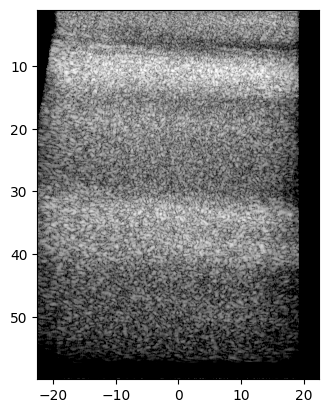

In [25]:
ims.shape

extent = 1E3*np.array([xout[0], xout[-1], zout[-1], zout[0]])

env = np.abs(hilbert(np.sum(ims[:], axis=0), axis=0))
logged = 20*np.log10(env/np.percentile(env, 99))
plt.figure()
plt.imshow(logged, vmin=-35, vmax=5, cmap='gray', extent=extent)
plt.show()